# Film segmentation

In [5]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np

from skimage.color import rgb2gray

img_path = "/media/luis/TOMO/Dosepy/BQT_INCAN/Tiff/fondo001.tif"
img = iio.imread(img_path)

from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib import colors

r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

In [6]:
pixel_colors = img.reshape((np.shape(img)[0]*np.shape(img)[1], 3))
norm = colors.Normalize(vmin=-1, vmax=1)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

In [ ]:
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter3D(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
plt.show()

In [ ]:
from skimage.color import rgb2hsv

hsv_img = rgb2hsv(img)

h = hsv_img[:,:,0]
s = hsv_img[:,:,1]
v = hsv_img[:,:,2]

fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

## Segmentation based on HSV 

In [6]:
import numpy.ma as ma

mask_h = ma.masked_less(h, 0.32)
mask_s = ma.masked_less(s, 0.35)
mask_v = ma.masked_less(v, 0.75)

film = 0*np.zeros(img.shape)

film[:,:,0]=mask_h.mask
film[:,:,1]=mask_s.mask
film[:,:,2]=mask_v.mask

In [ ]:
plt.imshow(film)

In [ ]:
mask_binary = np.logical_and(film[:,:,0], film[:,:,1], film[:,:,2])
plt.imshow(mask_binary)

In [ ]:
mask_binary

In [ ]:
plt.imshow(img/np.max(img))

In [ ]:
fig = plt.figure(tight_layout=True)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

ax1.hist(h.ravel(), 512)
ax1.set_title("Hue")
ax2.hist(s.ravel(), 512)
ax2.set_title("Saturation")
ax3.hist(v.ravel(), 512)
ax3.set_title("Value")
ax4.imshow(h)
ax5.imshow(s)
ax6.imshow(v)

In [12]:
hue_after_thresh = np.logical_and(h > 0.05, h < 0.29)
sat_after_thresh = s > 0.1
val_after_thresh = np.logical_and(v > 0.40, v < 0.9)
binary_img = np.logical_and(hue_after_thresh, sat_after_thresh, val_after_thresh)

In [ ]:
plt.imshow(binary_img)

In [4]:
import skimage
from skimage.morphology import square
from skimage.measure import label, regionprops
from numpy import ndarray
import imageio.v3 as iio
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv
import numpy as np

In [15]:

bi_img_filtered = skimage.morphology.binary_erosion(binary_img, mode="min", footprint=square(5))

In [ ]:
plt.imshow(bi_img_filtered)

In [7]:
def get_labeled_objects(
        img: ndarray,
        return_num: bool = False,
        show: bool = False,
        threshold: tuple[float, float] = (0.1, 0.8),
        min_area: float = 100
        ):
    """
    Get an array of labeled connected regions of an Image.

    Bright and black regions and also regions with an area less than a given value, are excluded.

    Parameters
    ----------

    Returns
    -------
    labeled_img : ndarray
        Image with labeled regions
    num_labels : int
        Number of labeled regions if return_num is True

    """
    # Convert to HSV
    hsv_img = rgb2hsv(img)
    #h = hsv_img[:, :, 0]
    #s = hsv_img[:, :, 1]
    v = hsv_img[:, :, 2]

    # Get binary with thresholding
    ## If v is LOW, it is a DARK region
    ## If v is HIGH, it is a BRIGHT region
    binary_img = np.logical_and(v > threshold[0], v < threshold[1])

    # Filter for small bright spots
    bi_img_filtered = skimage.morphology.binary_erosion(
        binary_img,
        mode="min",
        footprint=square(3)
        )

    # Get labeled regions and properties
    labeled_img = label(bi_img_filtered)
    properties = regionprops(label_image = labeled_img)

    # Remove objects with area less than 10 x 10 mm^2

    ## What is the number of pixels in 10 x 10 mm^2?
    ## [10 mm (1 inch / 25.4 mm) (300 pixels / 1 inch)]**2
    ##               ^- mm to inch       ^- inch to pixels

    minimum_area = int(min_area * (1/25.4)**2 * (75)**2)
    print(f"The minimum area in pixels is: {minimum_area}")

    film_counter = 0  # Used to reset label number

    for n, p in enumerate(properties, start = 1):
        
        if p.area < minimum_area:  # Remove small regions
            labeled_img[labeled_img == n] = 0

        else:
            film_counter += 1
            print(f"Object num. {film_counter}")
            labeled_img[labeled_img == n] = film_counter
            

    # Plot histogram if show is True
    if show:
        fig = plt.figure(tight_layout=True)
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        ax1.imshow(v)
        ax1.set_title("Value")
        ax2.hist(v.ravel(), 512)

    if return_num:
        return (labeled_img, film_counter)
    else:
        return labeled_img

# Testing the get_labeled_function

In [ ]:
cal_file_path = "/home/luis/Documents/GitHub/Dosepy/docs/Jupyter/cal_48h.tif"
#cal_file_path = "/home/luis/Dosepy/docs/Jupyter/cal_48h.tif"
img = iio.imread(cal_file_path)

fig = plt.figure()
axes = fig.subplots(1, 2)

labels, num = get_labeled_objects(img, show=True, return_num=True)
print(f"Number of detected films: {num}")
axes[0].imshow(labels)
axes[1].imshow(img/np.max(img))

In [ ]:
cal_file_path = "/home/luis/Documents/GitHub/Dosepy/docs/Jupyter/Calibracion_Post.tif"
#cal_file_path = "/home/luis/Dosepy/docs/Jupyter/Calibracion_Post.tif"
img = iio.imread(cal_file_path)

fig = plt.figure()
axes = fig.subplots(1, 2)

labels, num = get_labeled_objects(img, show=True, return_num=True)
print(f"Number of detected films: {num}")
axes[0].imshow(labels)
axes[1].imshow(img/np.max(img))

In [ ]:
cal_file_path = "/media/luis/TOMO/Tiff Films/EBT4/6NOV24_CAL/CAL20241106_001.tif"

img = iio.imread(cal_file_path)

fig = plt.figure()
axes = fig.subplots(1, 2)

labels, num = get_labeled_objects(img, show=True, return_num=True)
print(f"Number of detected films: {num}")
axes[0].imshow(labels)
axes[1].imshow(img/np.max(img))

In [ ]:

cal_file_path = "/media/luis/TOMO/Dosepy/BQT_INCAN/Tiff/fondo001.tif"

img = iio.imread(cal_file_path)

fig = plt.figure()
axes = fig.subplots(1, 2)

labels, num = get_labeled_objects(img, show=True, return_num=True)
print(f"Number of detected objects: {num}")
axes[0].imshow(labels)
axes[1].imshow(img/np.max(img))

In [ ]:
plt.hist(img.ravel())

In [ ]:

cal_file_path = "/home/luis/Dosepy/tests/unit/fixtures/CAL/film20240620_002.tif"

img = iio.imread(cal_file_path)

fig = plt.figure()
axes = fig.subplots(1, 2)

labels, num = get_labeled_objects(img, show=True, return_num=True)
print(f"Number of detected films: {num}")
axes[0].imshow(labels)
axes[1].imshow(img/np.max(img))

# Uso del método set_labeled_films_and_filters
## 10 ENE 2025

### Calibration file

In [ ]:
from Dosepy.image import load
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

file_path = "/home/luis/Documents/GitHub/Dosepy/tests/unit/fixtures/CAL20241106_001.tif"
file_path = "/home/luis/Dosepy/tests/unit/fixtures/Ver_050dpi20241106_001.tif"
img = load(file_path)
img.set_labeled_films_and_filters()

fig, axes = plt.subplots(1, 2)
axes[0].imshow(img.labeled_optical_filters)
axes[1].imshow(img.labeled_films)

labeled_filters = label(img.labeled_optical_filters)
properties = regionprops(labeled_filters, intensity_image=img.array[:,:,0])

for p in properties:
    print(f"Mean: {int(p.intensity_mean)}")
    print(f"STD: {int(p.intensity_std)}")

### Verification file

In [ ]:
file_path = "/home/luis/Dosepy/tests/unit/fixtures/Ver_050dpi20241106_001.tif"
img = load(file_path)
img.set_labeled_films_and_filters()

fig, axes = plt.subplots(1, 2)
axes[0].imshow(img.labeled_optical_filters)
axes[1].imshow(img.labeled_films)

labeled_filters = label(img.labeled_optical_filters)
properties = regionprops(labeled_filters, intensity_image=img.array[:,:,0])

for p in properties:
    print(f"Mean: {int(p.intensity_mean)}")
    print(f"STD: {int(p.intensity_std)}")



In [1]:
from Dosepy.tiff2dose import Tiff2DoseM
from Dosepy.image import load
from Dosepy.calibration import LUT
import matplotlib.pyplot as plt

cal_file_path = "/home/luis/Dosepy/tests/unit/fixtures/CAL20241106_001.tif"
cal_file_path = "/home/luis/Documents/GitHub/Dosepy/tests/unit/fixtures/CAL20241106_001.tif"
img_cal = load(cal_file_path)

cal = LUT(img_cal)
cal.set_central_rois((180, 8))
cal.set_doses([0, 0.5, 1, 2, 4, 6, 8, 10])
cal.set_beam_profile("/home/luis/Documents/GitHub/Dosepy/tests/unit/fixtures/CAL/BeamProfile.csv")
cal.compute_lateral_lut(filter=3)

file_path = "/home/luis/Documents/GitHub/Dosepy/tests/unit/fixtures/Ver_050dpi20241106_001.tif"
img = load(file_path)

dose_converter = Tiff2DoseM()
dose = dose_converter.get_dose(img, "RP", cal)

The minimum area in pixels is: 871
Object num. 1
Object num. 2
Object num. 3
Object num. 4
Object num. 5
Object num. 6
Object num. 7
Object num. 8
Object num. 9
Object num. 10
Object num. 11
The minimum area in pixels is: 871
Object num. 1
Object num. 2
Object num. 3
Object num. 4
Object num. 5
origin_index=array([91])
reference_intensity=array([40274])
Inside RedPolynomialDoseConverter.get_zero_dose_intensity method


/home/luis/miniconda3/envs/dp/lib/python3.11/site-packages/Dosepy/tools/functions.py:19: RuntimeWarning: divide by zero encountered in power
  return a*x + b*x**n
/home/luis/miniconda3/envs/dp/lib/python3.11/site-packages/Dosepy/tools/functions.py:19: RuntimeWarning: invalid value encountered in power
  return a*x + b*x**n


In [ ]:
dose_converter.dose_converter._get_zero_dose_intensity_at_center(img, "red")

In [ ]:
i, c = dose_converter.dose_converter._get_lateral_intensities_for_zero_dose(
    img, cal, "red"
)
len(i)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

5.178969708635302


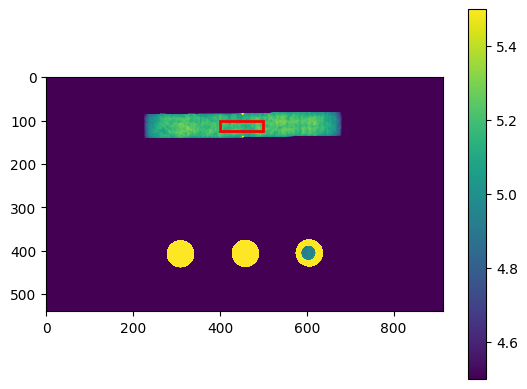

In [25]:
# Add a rectangle
from matplotlib.patches import Rectangle
rec = Rectangle((400, 100), 100, 25, fill = False, lw = 2, color = "red")

# Show the image with a colorbar
fig, ax = plt.subplots()
im = ax.imshow(dose, vmin=4.5, vmax=5.5)
ax.add_patch(rec)
fig.colorbar(im, ax = ax)

print(np.mean(dose[100:125, 400:500]))

In [5]:
from Dosepy.image import ArrayImage

dose_img = ArrayImage(dose*100, dpi=img.dpi)
dose_img.save_as_tif("dose.tif")

In [ ]:
cal.plot_fit("polynomial", "red", 0)

In [ ]:
cal.plot_dose_fit_uncertainty(0, "red", "polynomial")